In [258]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
import itertools
import seaborn as sn
from textblob import TextBlob
import glob

# warning
import warnings
warnings.filterwarnings("ignore")

In [259]:
df = pd.read_csv('../data/final_data.csv')
df.head(3)

,date,full_text,geo,truncated,display_text_range,user,tweet_id,entities,possibly_sensitive,longitude,...,yoursel,youth,youtube,yrxltdq,yummy,yumyum,yup,zero,zoom,sentiment
0,2020-03-30,Definitely making a routine to stop from going...,"[41.42362498, -122.39264801]",False,"[0, 239]","{'id': 988896150571790336, 'id_str': '98889615...",1244710975422574592,"{'hashtags': [], 'symbols': [], 'user_mentions...",False,-122.392648,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0625
1,2020-03-30,This is my 'self-isolating' face. #quarantine ...,"[34.1722, -118.378]",False,"[0, 140]","{'id': 1008423932267921408, 'id_str': '1008423...",1244710063589089281,"{'hashtags': [{'text': 'quarantine', 'indices'...",False,-118.378000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
2,2020-03-30,Corona virus testing and treatment is availabl...,"[33.97977, -118.18884]",False,"[0, 233]","{'id': 107183997, 'id_str': '107183997', 'name...",1244708953994469377,"{'hashtags': [], 'symbols': [], 'user_mentions...",False,-118.188840,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4000


In [260]:
# load in political party by county info
df_party = pd.read_csv('../data/political_party_bycounty.csv')
df_party = df_party.drop(labels='Unnamed: 0', axis = 1)
df_party.head()

,county,biden_votes,biden_percent,trump_votes,trump_percent,biden_yes
0,Alameda County,617486,80.2,136238,17.7,1
1,Alpine County,473,64.7,238,32.6,1
2,Amador County,8153,36.6,13585,60.9,0
3,Butte County,50416,49.4,48723,47.8,1
4,Calaveras County,9845,36.8,16287,61.0,0


In [261]:
irrelevant_cols = ['full_text', 'geo', 'display_text_range', 'user', 'tweet_id',
       'entities', 'longitude', 'latitude', 'state', 'preprocess_full_text']

In [262]:
relevant_cols = df.drop(columns=irrelevant_cols)
relevant_cols.head(2)

,date,truncated,possibly_sensitive,county,retail_rec,groc_pharm,parks,transit,workplaces,residential,...,yoursel,youth,youtube,yrxltdq,yummy,yumyum,yup,zero,zoom,sentiment
0,2020-03-30,False,False,Siskiyou County,-33.0,-12.0,-2.0,-12.0,-40.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0625
1,2020-03-30,False,False,Los Angeles County,-42.0,-23.0,-34.0,-52.0,-51.0,22.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000


In [263]:
# Length before dropping missing values
len(relevant_cols)

17531

In [264]:
# Drop rows with NaN values
no_na = relevant_cols.dropna()
no_na = no_na.merge(df_party, how = 'left')

In [265]:
# Length after dropping missing values
len(no_na)

15923

In [266]:
# One hot encode categorical columns
dummy_cols = ['county', 'truncated', 'possibly_sensitive']
ohe_df = pd.get_dummies(no_na, drop_first=True, columns=dummy_cols)
ohe_df.head(2)

,date,retail_rec,groc_pharm,parks,transit,workplaces,residential,public,polarity,aad,...,county_Shasta County,county_Siskiyou County,county_Solano County,county_Sonoma County,county_Stanislaus County,county_Tulare County,county_Ventura County,county_Yolo County,truncated_True,possibly_sensitive_True
0,2020-03-30,-33.0,-12.0,-2.0,-12.0,-40.0,10.0,-24.25,-0.0625,0.0,...,0,1,0,0,0,0,0,0,0,0
1,2020-03-30,-42.0,-23.0,-34.0,-52.0,-51.0,22.0,-42.00,0.0000,0.0,...,0,0,0,0,0,0,0,0,0,0


In [267]:
# Add county back
ohe_df['county'] = no_na['county']
ohe_df.head(1)

,date,retail_rec,groc_pharm,parks,transit,workplaces,residential,public,polarity,aad,...,county_Siskiyou County,county_Solano County,county_Sonoma County,county_Stanislaus County,county_Tulare County,county_Ventura County,county_Yolo County,truncated_True,possibly_sensitive_True,county
0,2020-03-30,-33.0,-12.0,-2.0,-12.0,-40.0,10.0,-24.25,-0.0625,0.0,...,1,0,0,0,0,0,0,0,0,Siskiyou County


In [268]:
y_labels = ohe_df.loc[:, ['retail_rec',
       'groc_pharm', 'parks', 'transit', 'workplaces', 'residential', 'public']]
y_labels.head()

,retail_rec,groc_pharm,parks,transit,workplaces,residential,public
0,-33.0,-12.0,-2.0,-12.0,-40.0,10.0,-24.25
1,-42.0,-23.0,-34.0,-52.0,-51.0,22.0,-42.00
2,-42.0,-23.0,-34.0,-52.0,-51.0,22.0,-42.00
3,-42.0,-23.0,-34.0,-52.0,-51.0,22.0,-42.00
4,-42.0,-23.0,-34.0,-52.0,-51.0,22.0,-42.00


In [269]:
# minus_first_20 = df.iloc[:, 20:]
# minus_first_20['date'] = df['date']
# minus_first_20['county'] = df['county']
# new_df = minus_first_20
# new_df.head()

In [319]:
grouped = ohe_df.groupby(['county','date']).mean()
grouped.head(2)

retail_rec  groc_pharm  parks  transit  workplaces  \
county         date                                                             
Alameda County 2020-03-30       -48.0       -23.0   -1.0    -71.0       -64.0   
               2020-04-01       -48.0       -18.0    0.0    -70.0       -65.0   

                           residential  public  polarity  aad  abc  ...  \
county         date                                                 ...   
Alameda County 2020-03-30         27.0  -51.50  0.233333  0.0  0.0  ...   
               2020-04-01         28.0  -50.25  0.221645  0.0  0.0  ...   

                           county_Shasta County  county_Siskiyou County  \
county         date                                                       
Alameda County 2020-03-30                   0.0                     0.0   
               2020-04-01                   0.0                     0.0   

                           county_Solano County  county_Sonoma County  \
county         date                                                     
Alameda County 2020-03-30                   0.0                   0.0   
               2020-04-01                   0.0                   0.0   

                           county_Stanislaus County  county_Tulare County  \
county         date                                                         
Alameda County 2020-03-30                       0.0                   0.0   
               2020-04-01                       0.0                   0.0   

                           county_Ventura County  county_Yolo County  \
county         date                                                    
Alameda County 2020-03-30                    0.0                 0.0   
               2020-04-01                    0.0                 0.0   

                           truncated_True  possibly_sensitive_True  
county         date                                                 
Alameda County 2020-03-30             0.0                      0.0  
               2020-04-01             0.0                      1.0  

[2 rows x 2337 columns]

In [320]:
len(grouped)

2540

In [321]:
reset_ind = grouped.reset_index()
reset_ind.drop(columns=['county'], inplace=True)

In [322]:
final_df = reset_ind
final_df.head(2)

,date,retail_rec,groc_pharm,parks,transit,workplaces,residential,public,polarity,aad,...,county_Shasta County,county_Siskiyou County,county_Solano County,county_Sonoma County,county_Stanislaus County,county_Tulare County,county_Ventura County,county_Yolo County,truncated_True,possibly_sensitive_True
0,2020-03-30,-48.0,-23.0,-1.0,-71.0,-64.0,27.0,-51.50,0.233333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-04-01,-48.0,-18.0,0.0,-70.0,-65.0,28.0,-50.25,0.221645,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [323]:
mobility_columns = list(final_df.columns)[1:8]
mobility_columns

['retail_rec',
 'groc_pharm',
 'parks',
 'transit',
 'workplaces',
 'residential',
 'public']

In [324]:
y_public = final_df['public']
y_residential = final_df['residential']

In [325]:
# Convert date column to pd.DateTime object
final_df['date'] = pd.to_datetime(final_df['date'])
type(final_df['date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [326]:
final_df['date_num'] = (final_df['date'] - pd.to_datetime('03/30/2020'))/np.timedelta64(1, 'D')
final_df = final_df.sort_values(by='date')
final_df.head(2)

,date,retail_rec,groc_pharm,parks,transit,workplaces,residential,public,polarity,aad,...,county_Siskiyou County,county_Solano County,county_Sonoma County,county_Stanislaus County,county_Tulare County,county_Ventura County,county_Yolo County,truncated_True,possibly_sensitive_True,date_num
0,2020-03-30,-48.0,-23.0,-1.0,-71.0,-64.0,27.0,-51.50,0.233333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1028,2020-03-30,-34.0,-18.0,-30.0,-35.0,-44.0,17.0,-32.75,0.068750,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0


In [327]:
before_mid_june = final_df[final_df['date'] < pd.to_datetime('2020-06-15')]
mid_june_onwards = final_df[final_df['date'] >= pd.to_datetime('2020-06-15')]
mid_june_onwards.tail(5)

,date,retail_rec,groc_pharm,parks,transit,workplaces,residential,public,polarity,aad,...,county_Siskiyou County,county_Solano County,county_Sonoma County,county_Stanislaus County,county_Tulare County,county_Ventura County,county_Yolo County,truncated_True,possibly_sensitive_True,date_num
971,2020-09-20,-27.0,-10.0,14.0,-38.0,-17.0,6.0,-23.0,0.146667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,174.0
2513,2020-09-20,-22.0,-14.0,12.0,-11.0,-17.0,5.0,-16.0,0.321528,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.000000,174.0
1942,2020-09-20,-17.0,-2.0,13.0,-33.0,-12.0,3.0,-16.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,174.0
1202,2020-09-20,-22.0,-9.0,-31.0,-30.0,-23.0,5.0,-21.0,0.125805,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.176471,174.0
277,2020-09-20,-30.0,-12.0,12.0,-38.0,-16.0,6.0,-24.0,0.016667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,174.0


In [328]:
list(before_mid_june.columns)[2294]

'zoom'

In [418]:
less_cols = list(before_mid_june.columns)[0:8]
less_cols2 = list(before_mid_june.columns)[2295:]

In [419]:
less_cols

['date',
 'retail_rec',
 'groc_pharm',
 'parks',
 'transit',
 'workplaces',
 'residential',
 'public']

In [420]:
less_cols2

['sentiment',
 'biden_votes',
 'biden_percent',
 'trump_votes',
 'trump_percent',
 'biden_yes',
 'county_Contra Costa County',
 'county_Fresno County',
 'county_Humboldt County',
 'county_Imperial County',
 'county_Kern County',
 'county_Kings County',
 'county_Lake County',
 'county_Los Angeles County',
 'county_Madera County',
 'county_Marin County',
 'county_Mendocino County',
 'county_Merced County',
 'county_Monterey County',
 'county_Napa County',
 'county_Nevada County',
 'county_Orange County',
 'county_Placer County',
 'county_Riverside County',
 'county_Sacramento County',
 'county_San Bernardino County',
 'county_San Diego County',
 'county_San Joaquin County',
 'county_San Luis Obispo County',
 'county_San Mateo County',
 'county_Santa Barbara County',
 'county_Santa Clara County',
 'county_Santa Cruz County',
 'county_Shasta County',
 'county_Siskiyou County',
 'county_Solano County',
 'county_Sonoma County',
 'county_Stanislaus County',
 'county_Tulare County',
 'county_V

In [421]:
few_cols_train = before_mid_june.loc[:, less_cols+less_cols2]
few_cols_test = mid_june_onwards.loc[:, less_cols+less_cols2]

In [422]:
few_cols_test = few_cols_test.iloc[:, 8:]
few_cols_train = few_cols_train.iloc[:, 8:]

In [423]:
y_public_train = np.array(before_mid_june.public)
y_public_test = np.array(mid_june_onwards.public)
y_residential_train = np.array(before_mid_june.residential)
y_residential_test = np.array(mid_june_onwards.residential)
y_wp_train = np.array(before_mid_june.workplaces)
y_wp_test = np.array(mid_june_onwards.workplaces)

    
y_groc_train = np.array(before_mid_june.groc_pharm)
y_groc_test = np.array(mid_june_onwards.groc_pharm)

y_parks_train = np.array(before_mid_june.parks)
y_parks_test = np.array(mid_june_onwards.parks)

y_transit_train = np.array(before_mid_june.transit)
y_transit_test = np.array(mid_june_onwards.transit)

y_retail_train = np.array(before_mid_june.retail_rec)
y_retail_test = np.array(mid_june_onwards.retail_rec)

In [424]:
few_cols_train.columns

Index(['sentiment', 'biden_votes', 'biden_percent', 'trump_votes',
       'trump_percent', 'biden_yes', 'county_Contra Costa County',
       'county_Fresno County', 'county_Humboldt County',
       'county_Imperial County', 'county_Kern County', 'county_Kings County',
       'county_Lake County', 'county_Los Angeles County',
       'county_Madera County', 'county_Marin County',
       'county_Mendocino County', 'county_Merced County',
       'county_Monterey County', 'county_Napa County', 'county_Nevada County',
       'county_Orange County', 'county_Placer County',
       'county_Riverside County', 'county_Sacramento County',
       'county_San Bernardino County', 'county_San Diego County',
       'county_San Joaquin County', 'county_San Luis Obispo County',
       'county_San Mateo County', 'county_Santa Barbara County',
       'county_Santa Clara County', 'county_Santa Cruz County',
       'county_Shasta County', 'county_Siskiyou County',
       'county_Solano County', 'county_Sonom

In [425]:
few_cols_train.head(2)

,sentiment,biden_votes,biden_percent,trump_votes,trump_percent,biden_yes,county_Contra Costa County,county_Fresno County,county_Humboldt County,county_Imperial County,...,county_Siskiyou County,county_Solano County,county_Sonoma County,county_Stanislaus County,county_Tulare County,county_Ventura County,county_Yolo County,truncated_True,possibly_sensitive_True,date_num
0,0.233333,617486,80.2,136238,17.7,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1028,0.068750,527475,53.0,448281,45.0,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0


In [426]:
final_df.head(2)

,date,retail_rec,groc_pharm,parks,transit,workplaces,residential,public,polarity,aad,...,county_Siskiyou County,county_Solano County,county_Sonoma County,county_Stanislaus County,county_Tulare County,county_Ventura County,county_Yolo County,truncated_True,possibly_sensitive_True,date_num
0,2020-03-30,-48.0,-23.0,-1.0,-71.0,-64.0,27.0,-51.50,0.233333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1028,2020-03-30,-34.0,-18.0,-30.0,-35.0,-44.0,17.0,-32.75,0.068750,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0


### load in the political party csv:

In [427]:
#df_party = pd.read_csv('../data/political_party_bycounty.csv')
#df_party = df_party.drop(labels='Unnamed: 0', axis = 1)
#df_party

In [428]:
#df_party = df_party.drop(labels='Unnamed: 0', axis = 1)
#df_party

In [429]:
final_df.public.describe()

count    2540.000000
mean      -29.099213
std        11.325797
min       -60.750000
25%       -36.250000
50%       -29.250000
75%       -21.250000
max        10.500000
Name: public, dtype: float64

In [430]:
final_df.residential.describe()

count    2540.000000
mean       13.557480
std         6.463355
min         0.000000
25%         9.000000
50%        13.000000
75%        17.000000
max        35.000000
Name: residential, dtype: float64

In [431]:
final_df

,date,retail_rec,groc_pharm,parks,transit,workplaces,residential,public,polarity,aad,...,county_Siskiyou County,county_Solano County,county_Sonoma County,county_Stanislaus County,county_Tulare County,county_Ventura County,county_Yolo County,truncated_True,possibly_sensitive_True,date_num
0,2020-03-30,-48.0,-23.0,-1.0,-71.0,-64.0,27.0,-51.50,0.233333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1028,2020-03-30,-34.0,-18.0,-30.0,-35.0,-44.0,17.0,-32.75,0.068750,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.0
801,2020-03-30,-44.0,-22.0,-21.0,-51.0,-51.0,23.0,-42.00,0.126970,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
783,2020-03-30,-44.0,-26.0,-44.0,-71.0,-43.0,15.0,-46.00,0.500000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1943,2020-03-30,-51.0,-25.0,4.0,-74.0,-73.0,32.0,-55.75,-0.060714,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
971,2020-09-20,-27.0,-10.0,14.0,-38.0,-17.0,6.0,-23.00,0.146667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,174.0
2513,2020-09-20,-22.0,-14.0,12.0,-11.0,-17.0,5.0,-16.00,0.321528,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.000000,174.0
1942,2020-09-20,-17.0,-2.0,13.0,-33.0,-12.0,3.0,-16.00,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,174.0
1202,2020-09-20,-22.0,-9.0,-31.0,-30.0,-23.0,5.0,-21.00,0.125805,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.176471,174.0


### Split into train & test

In [432]:
def get_X_train_test(df):
    X_train = df[df['date'] < pd.to_datetime('2020-06-15')]
    X_test = df[df['date'] >= pd.to_datetime('2020-06-15')]
    return (X_train, X_test)

In [433]:
def get_X_y_train_test(df_train, df_test, cols_to_drop = mobility_columns+['date'], public=True):
    X_train = df_train.drop(columns=cols_to_drop)
    y_public_train = np.array(df_train['public'])
#     y_residential_train = df_train['residential']
    X_test = df_test.drop(columns=cols_to_drop)
    y_public_test = np.array(df_test['public'])
#     y_residential_test = df_test['residential']
    return (X_train, X_test, y_public_train, y_public_test)

In [434]:
#plt.scatter(before_mid)

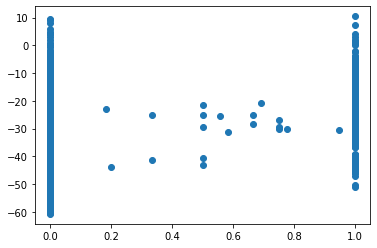

In [435]:
plt.scatter(final_df['truncated_True'], final_df['public'])

In [436]:
#few_cols_train = few_cols_train.iloc[:,8:]
#few_cols_test = few_cols_test.iloc[:, 8:]
#few_cols_test

In [437]:
few_cols_train = few_cols_train.drop(labels= ['date_num'], axis = 1)
few_cols_test = few_cols_test.drop(labels= ['date_num'], axis = 1)

In [438]:
#y_public_

### Build the linear model

In [439]:
#public
lm = linear_model.LinearRegression()
lm.fit(few_cols_train, y_public_train)
y_public_pred = lm.predict(few_cols_test)

#residential
lm_residential = linear_model.LinearRegression()
lm_residential.fit(few_cols_train, y_residential_train)
y_residential_pred = lm_residential.predict(few_cols_test)

#workplaces
lm_wp = linear_model.LinearRegression()
lm_wp.fit(few_cols_train, y_wp_train)
y_wp_pred = lm_wp.predict(few_cols_test)

#retail_rec',
lm_retail = linear_model.LinearRegression()
lm_retail.fit(few_cols_train, y_retail_train)
y_retail_pred = lm_retail.predict(few_cols_test)

#groc_pharm',
lm_groc = linear_model.LinearRegression()
lm_groc.fit(few_cols_train, y_groc_train)
y_groc_pred = lm_groc.predict(few_cols_test)

#parks',
lm_parks = linear_model.LinearRegression()
lm_parks.fit(few_cols_train, y_parks_train)
y_parks_pred = lm_parks.predict(few_cols_test)

#transit'
lm_transit = linear_model.LinearRegression()
lm_transit.fit(few_cols_train, y_transit_train)
y_transit_pred = lm_transit.predict(few_cols_test)

In [440]:
#public
sum(y_public_pred == y_public_test) / len(y_public_test)

0.0

In [441]:
#residential
sum(y_residential_pred == y_residential_test) / len(y_residential_test)

#workplaces 

sum(y_wp_pred == y_wp_test) / len(y_wp_test)

0.0

In [442]:
y_public_pred[:20]

array([-51.37645936, -46.86195078, -28.44929732, -30.65071089,
       -49.71917841, -31.89411708, -38.23864888, -39.90118053,
       -31.56985804, -25.90394487, -25.88576153, -33.08937994,
       -32.66717409, -37.5879405 , -20.15027771, -37.99095725,
       -37.33873793, -31.98913386, -50.5330735 , -37.28296907])

In [443]:
y_residential_pred

array([26.18124373, 22.64555149, 15.15066538, ..., 12.83684187,
       14.69913074, 18.61752611])

In [444]:
np.array(y_public_test[:20])

array([-45.  , -44.5 , -21.75, -21.75, -45.5 , -17.5 , -31.5 , -32.5 ,
       -26.  , -23.  , -17.25, -25.5 , -27.5 , -34.25, -17.  , -29.75,
       -29.5 , -24.  , -43.25, -28.25])

In [445]:
np.array(y_residential_test[:20])

array([24., 21., 12., 10., 25.,  9., 13., 14., 12., 11.,  9.,  9., 12.,
       16.,  9., 14., 15., 12., 25., 16.])

In [446]:
def get_accuracy(pred_y, actual_y, margin=0):
    accuracies = []
    for i in range(len(pred_y)):
        if (abs(pred_y[i] - actual_y[i]) <= margin):
            accuracies.append(1)
        else:
            accuracies.append(0)
    return sum(accuracies)/len(accuracies)

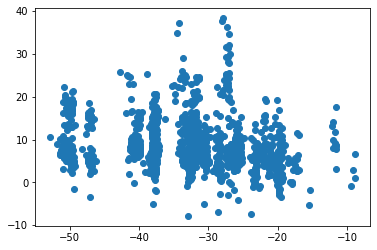

In [447]:
residuals = y_public_test - y_public_pred
plt.scatter(y_public_pred, residuals)

In [460]:
get_accuracy(y_public_pred, y_public_test, margin=10)

0.720808871493803

In [458]:
get_accuracy(y_residential_pred, y_residential_test, margin=10)

0.8538812785388128

In [461]:
get_accuracy(y_wp_pred, y_wp_test, margin = 10)

0.6836268754076973

In [462]:
get_accuracy(y_retail_pred, y_retail_test, margin = 10)

0.091324200913242

In [457]:
get_accuracy(y_groc_pred, y_groc_test, margin = 10)

0.9360730593607306

In [463]:
get_accuracy(y_parks_pred, y_parks_test, margin = 10)

0.16829745596868884

In [466]:
get_accuracy(y_transit_pred, y_transit_test, margin = 10)

0.7084148727984344